# Simulatie Neutral model Fisher Mehta 2014 PNAS

In [1]:
import numpy as np
import time
from noise_analysis import *

from neutral_covariance_test import *
from neutrality_analysis import *

np.random.seed(int(time.time()))

import matplotlib.pyplot as plt
%matplotlib inline

import collections

from noise_properties_plotting import *

def cm2inch(value):
    return value/2.54;

/Users/wkits/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
textwidth = cm2inch(14) #5.5
fullwidth = cm2inch(18.5)

fontsize = 7 

#font = {'family': 'Arial', 'size': 9}
font = {'family': 'Open Sans', 'size': fontsize}
mpl.rc('font', **font)
mpl.rc('legend', handlelength=1)

mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['figure.titlesize'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.labelpad'] = 4

mpl.rcParams["legend.borderaxespad"] = 0.2
mpl.rcParams["legend.handlelength"] = 0.8
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['lines.linewidth'] = 0.8

In [24]:
def plottimeseries(data):
    if isinstance(data, pd.DataFrame):
        fig = plt.figure(figsize=(8,3))
        
        skip = max(1, int(len(data)/500))
        
        ax = fig.add_subplot(1,2,1)
        for i in range(1, len(data.columns)-1, 1): # 5):
            ax.plot(data.index[::skip], data['species_%d' % i][::skip])
        ax.set_ylabel("Number species")
        
        ax = fig.add_subplot(1,2,2)
        ax.plot(np.sum(data.values, axis=1)[::skip])
        ax.set_ylabel("Total number species")
    else:
        fig = plt.figure(figsize=(8,3))
        
        skip = max(1, int(len(data)/500))
        
        ax = fig.add_subplot(1,2,1)
        for i in range(1, len(data[0])-1, 1): #5):
            ax.plot(data[::skip, i])
        ax.set_ylabel("Number species")
        
        ax = fig.add_subplot(1,2,2)
        ax.plot(np.sum(data, axis=1)[::skip])
        ax.set_ylabel("Total number species")

    plt.show()

In [41]:
class NeutralityTest(Enum):
    KULLBACKLEIBLER = 1
    COVARIANCE = 2

def plot_neutrality(f, type=NeutralityTest.KULLBACKLEIBLER, ax = 0, ax_clb=0):
    if isinstance(f, str):
        df = pd.read_csv(f, index_col=0)
    elif isinstance(f, list): # average of all files
        df = pd.DataFrame(np.nanmedian([pd.read_csv(fi, index_col=0).values for fi in f], axis=0),
                          columns = pd.read_csv(f[0], index_col=0).columns, 
                          index=pd.read_csv(f[0], index_col=0).index)
        df[df == np.inf] = 1e4
        
    if ax == 0:
        fig = plt.figure()
        
        gs = gridspec.GridSpec(1,2,width_ratios=[9,1], wspace=0.3)

        ax = fig.add_subplot(gs[0])
        ax_clb = fig.add_subplot(gs[1])
    
    ax.set_facecolor('lightgrey')
    
    if type == NeutralityTest.KULLBACKLEIBLER:
        vmin = -1; vmax = 3
        mat = ax.matshow(np.log10(df.T), origin='lower', cmap='Blues_r', aspect='auto', vmin=vmin, vmax=vmax)
    elif type == NeutralityTest.COVARIANCE:
        vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
        norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
        mat = ax.matshow(np.log10(df.T), origin='lower', norm=norm, cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
    
    skiplabel = 0
    
    ax.set_xticks(range(0, df.shape[0], (skiplabel+1)))
    ax.set_xticklabels(['%d' % i for i in df.index][::(skiplabel+1)])
    ax.set_yticks(range(0, df.shape[1], (skiplabel+1)))
    ax.set_yticklabels(['%.3f' % i for i in df.columns.astype(float)][::(skiplabel+1)])
    ax.set_xlabel('Size community')
    ax.set_ylabel(r'Immigration probability $\lambda$')
    
    if ax_clb != 0:
        plt.colorbar(mat, cax=ax_clb)
    
        if type == NeutralityTest.KULLBACKLEIBLER:
            ax_clb.set_title(r'log$_{10}$(D$_{KL}$)')
            
            ax_clb2 = ax_clb.twinx()
            ax_clb2.yaxis.set_ticks_position('right')
            ax_clb.yaxis.set_ticks_position('left')
            ax_clb2.yaxis.set_ticks([0.05,0.95])
            ax_clb2.set_ylim([0,1])
            ax_clb2.yaxis.set_ticklabels(['neutral','niche'])

        elif type == NeutralityTest.COVARIANCE:
            ax_clb.set_title(r'log$_{10}$($p_{NCT}$)')
            ax_clb2 = ax_clb.twinx()
            ax_clb2.yaxis.set_ticks_position('right')
            ax_clb.yaxis.set_ticks_position('left')
            ax_clb2.yaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                                    1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
            ax_clb2.set_ylim([0,1])
            ax_clb2.yaxis.set_ticklabels(['niche','neutral'])



In [5]:
new = False

lamda = 0.01 #01 # immigration probability

T = int(1e7)
tskip = 999

S = 50 # amount of different species
J = 5000 # 1e3 # Number of individuals in the community

f = 'test_neutral4.txt'

def neutral_timeseries(S, lamda, J, tskip = 1e3, T = int(1e6), f = 0):
    initcond = np.arange(J/S, J+1, J/S)
    
    x = np.copy(initcond)
    x_ts = np.copy(initcond)
    
    # save x as cumulative distribution, it makes simulations faster
    
    for i in range(T):
        if i % 1e6 == 0:
            print(i)
        
        if np.random.uniform(0,1) < lamda: # immigration from outside pool
            immi = int(np.random.uniform()*S)
            x[immi:] += 1
        else:
            growing = int(np.random.uniform()*J)

            x[x > growing] += 1

        dead = int(np.random.uniform()*(J+1)) 

        x[x > dead] -= 1
        
        if i % (tskip + 1) == 0:
            x_ts = np.vstack((x_ts, x))
    
    # transform cumulative distribution into abundances
    
    for i in range(1,S):
        x_ts[:,-i] = x_ts[:,-i] - x_ts[:,-i-1]
    
    if f != 0:
        np.savetxt(f, x_ts, fmt='%d')
    
    return x_ts

if new:
    neutral_timeseries(S, lamda, J, tskip, T, f)

In [ ]:
lamda = 0.1 # immigration probability

S = 50 # amount of different species
J = 5000 # 1e3 # Number of individuals in the community

x_ts = neutral_timeseries(S, lamda, J, tskip = 0, T = int(1e4))

for i in range(len(x_ts[0])):
    plt.plot(range(1001), x_ts[:,i])

for i in range(len(x_ts)):
    x_ts[i] /= sum(x_ts[i])

print('KL', KullbackLeibler_neutrality(x_ts)) #, verbose=True))
print(neutral_covariance_test(x_ts, ntests=500, method = 'Kolmogorov'))

plt.show()

In [21]:
new = False 

def neutral_measures(fKL, fNCT, 
                     Js=[50,100,500,1000,2500,5000], 
                     lamdas=[0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]):
    KL = np.zeros([len(Js),len(lamdas)])
    NCT = np.zeros([len(Js),len(lamdas)])
    
    for i, J in enumerate(Js):
        for j, lamda in enumerate(lamdas):
            print(J, lamda)
            
            x_ts = neutral_timeseries(S, lamda, J, tskip = 0, T = int(1e4))
            
            KL[i,j] = KullbackLeibler_neutrality(x_ts[:,:-1])
            
            for k in range(len(x_ts)):
                s = sum(x_ts[k])
                if s > 0:
                    x_ts[k] /= s
    
            NCT[i,j] = neutral_covariance_test(x_ts, ntests=500, method = 'Kolmogorov')
    
    KL = pd.DataFrame(KL, index=Js, columns=lamdas)
    KL.to_csv(fKL)
    
    NCT = pd.DataFrame(NCT, index=Js, columns=lamdas)
    NCT.to_csv(fNCT)
    
    return KL, NCT

if new:
    for i in range(107,110):
        fKL = 'KullbackLeibler/Mehta2A/KL-1e7-%d.csv' % i
        fNCT = 'KullbackLeibler/Mehta2A/NCT-1e7-%d.csv' % i
        KL, NCT = neutral_measures(fKL, fNCT)

fKL = 'KullbackLeibler/Mehta2A/KL-1e4-check.csv'
fNCT = 'KullbackLeibler/Mehta2A/NCT-1e4-check.csv'
KL, NCT = neutral_measures(fKL, fNCT, Js=[50,100,500], lamdas=[0.001,0.1,0.5])
        
#print(KL)


50 0.001
0
CVT test: number of timepoints: 10001, number of species: 50
50 0.1
0
CVT test: number of timepoints: 10001, number of species: 50
50 0.5
0
CVT test: number of timepoints: 10001, number of species: 50
100 0.001
0
CVT test: number of timepoints: 10001, number of species: 50
100 0.1
0
CVT test: number of timepoints: 10001, number of species: 50
100 0.5
0
CVT test: number of timepoints: 10001, number of species: 50
500 0.001
0
CVT test: number of timepoints: 10001, number of species: 50
500 0.1
0
CVT test: number of timepoints: 10001, number of species: 50
500 0.5
0
CVT test: number of timepoints: 10001, number of species: 50


/Users/wkits/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10


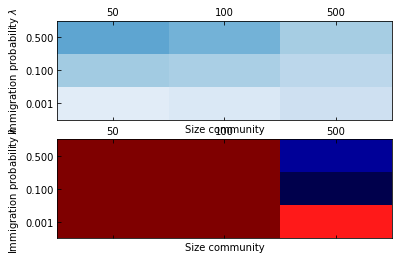

In [22]:
fig = plt.figure()
ax_KL = fig.add_subplot(211)
ax_NCT = fig.add_subplot(212)
plot_neutrality(['KullbackLeibler/Mehta2A/KL-1e4-check.csv'],
                       ax = ax_KL)
plot_neutrality(['KullbackLeibler/Mehta2A/NCT-1e4-check.csv'], 
                        type=NeutralityTest.COVARIANCE,
                       ax = ax_NCT)

plt.show()

/Users/wkits/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10
/Users/wkits/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


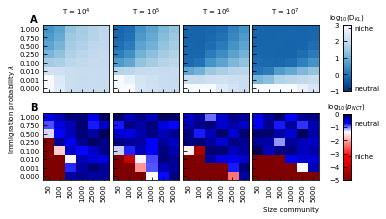

In [42]:
fig = plt.figure(figsize=(textwidth,3))

gs = gridspec.GridSpec(2,4, wspace=0.05, hspace=0.3, right=0.82, bottom=0.18, top=0.9)
gs_clb = gridspec.GridSpec(2,1, hspace=0.35, top=0.9, bottom=0.18, left=0.88, right=0.9)
gs_tot = gridspec.GridSpec(1,1, top=0.95, bottom=0.08, left=0.07, right=0.82)

for i, s in enumerate(['1e4', '1e5', '1e6', '1e7']):
    ax_KL = fig.add_subplot(gs[0, i])
    ax_NCT = fig.add_subplot(gs[1, i])
    ax_clb_KL = fig.add_subplot(gs_clb[0])
    ax_clb_NCT = fig.add_subplot(gs_clb[1])
    
    ax_KL.set_title('T = 10$^{%d}$' % int(s[-1]))
    
    if i == 0:
        plot_neutrality(['KullbackLeibler/Mehta2A/KL-%s-' % s + '%d.csv' % j for j in range(0, 6)],
                       ax = ax_KL, ax_clb = ax_clb_KL)
        plot_neutrality(['KullbackLeibler/Mehta2A/NCT-%s-'% s + '%d.csv' % j for j in range(0, 6)], 
                        type=NeutralityTest.COVARIANCE,
                       ax = ax_NCT, ax_clb = ax_clb_NCT)
        
        ax_KL.tick_params(axis="both", bottom=True, labelbottom=False, top = False, labeltop=False, 
                          left=True, labelleft=True)
        ax_NCT.tick_params(axis="both", bottom=True, labelbottom=True, top = False, labeltop=False, 
                           left=True, labelleft=True)
        
        ax_KL.text(-0.08, 1.15, 'A', transform=ax_KL.transAxes,
              fontsize=10, fontweight='bold', va='top', ha='right')
        ax_NCT.text(-0.08, 1.15, 'B', transform=ax_NCT.transAxes,
              fontsize=10, fontweight='bold', va='top', ha='right')

    else:
        plot_neutrality(['KullbackLeibler/Mehta2A/KL-%s-' % s + '%d.csv' % j for j in range(0, 6)],
                       ax = ax_KL)
        plot_neutrality(['KullbackLeibler/Mehta2A/NCT-%s-'% s + '%d.csv' % j for j in range(0, 6)], 
                        type=NeutralityTest.COVARIANCE,
                       ax = ax_NCT)
    
        ax_KL.tick_params(axis="both", bottom=True, labelbottom=False, top = False, labeltop=False, 
                          left=True, labelleft=False)
        ax_NCT.tick_params(axis="both", bottom=True, labelbottom=True, top = False, labeltop=False, 
                           left=True, labelleft=False)
    
    ax_NCT.tick_params(axis='x', rotation=90)
        
    ax_KL.set_xlabel('')
    ax_NCT.set_xlabel('')
    ax_KL.set_ylabel('')
    ax_NCT.set_ylabel('')

ax = fig.add_subplot(gs_tot[0], frameon=False)
ax.tick_params(axis="both", bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_xlabel('Size community', x=1, ha='right')
ax.set_ylabel('Immigration probability $\lambda$')

plt.savefig('figures_elife/supplemental/neutrality_measures_median3.pdf')
plt.show()

timeseries/J-2500-immi-0-T-1e4.csv


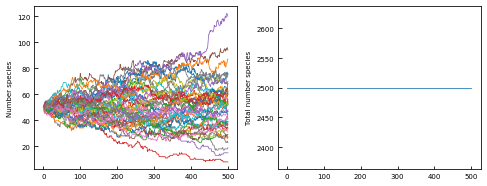

timeseries/J-2500-immi-0-T-1e5.csv


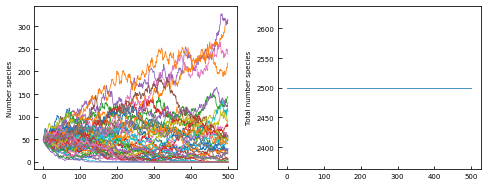

timeseries/J-2500-immi-0-T-1e6.csv


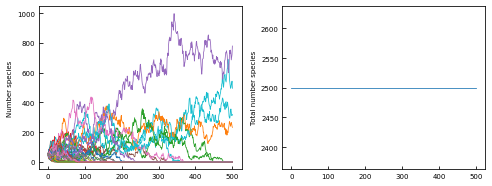

timeseries/J-2500-immi-0-T-1e7.csv


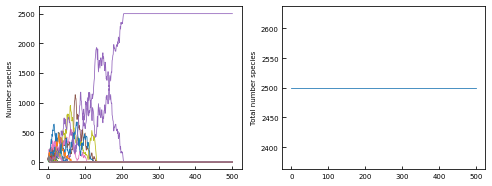

timeseries/J-2500-immi-10-T-1e4.csv


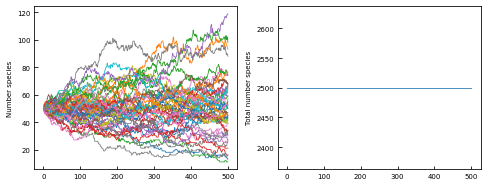

timeseries/J-2500-immi-10-T-1e5.csv


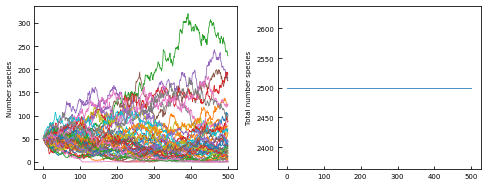

timeseries/J-2500-immi-10-T-1e6.csv


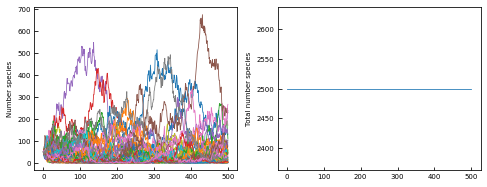

timeseries/J-2500-immi-10-T-1e7.csv


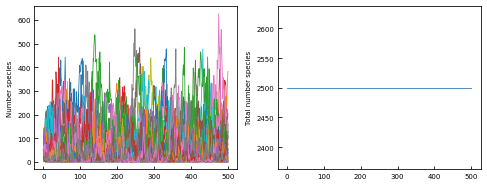

timeseries/J-50-immi-0-T-1e4.csv


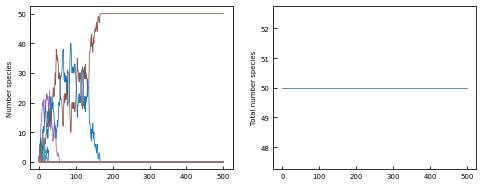

timeseries/J-50-immi-0-T-1e5.csv


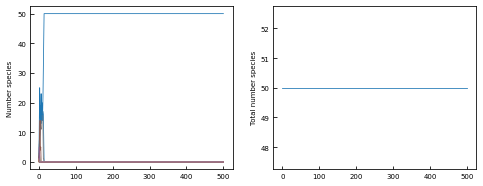

timeseries/J-50-immi-0-T-1e6.csv


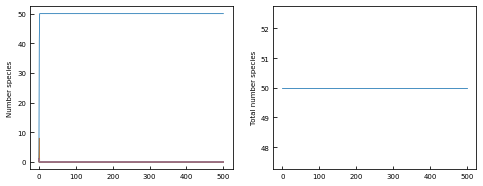

timeseries/J-50-immi-0-T-1e7.csv


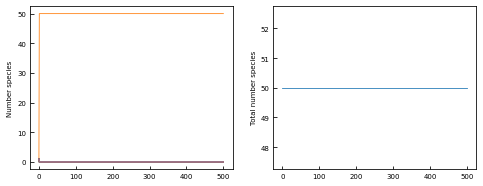

timeseries/J-50-immi-10-T-1e4.csv


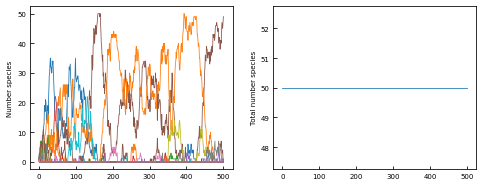

timeseries/J-50-immi-10-T-1e5.csv


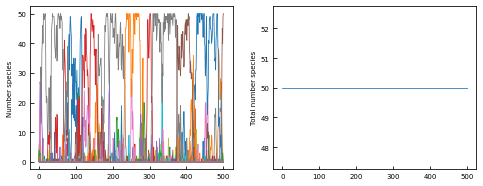

timeseries/J-50-immi-10-T-1e6.csv


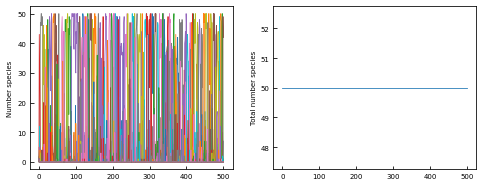

timeseries/J-50-immi-10-T-1e7.csv


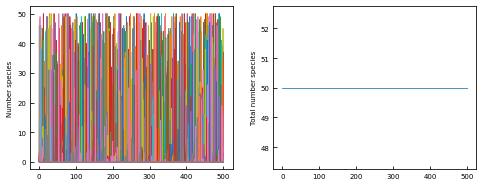

timeseries/J-500-immi-10-T-1e4.csv


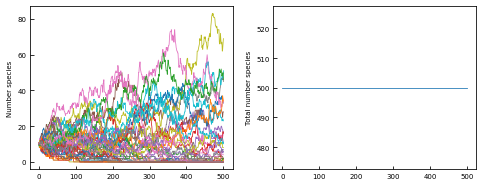

timeseries/J-500-immi-10-T-1e5.csv


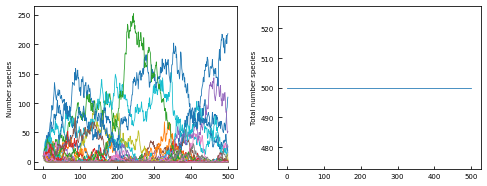

timeseries/J-500-immi-10-T-1e6.csv


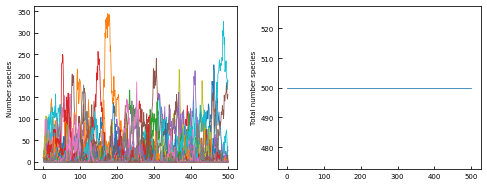

timeseries/J-500-immi-10-T-1e7.csv


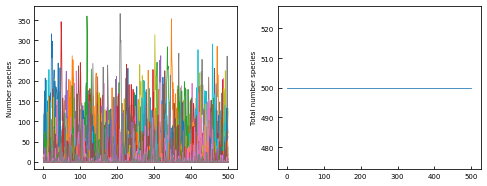

In [36]:
import glob

for f in glob.glob('timeseries/J*.csv'):
    print(f)
    ts = np.loadtxt(f)
    plottimeseries(ts)

In [20]:
# Dirichlet multinomial
# Is this a good definition?

x = np.random.uniform(0,1,[1000, 50])

np.savetxt('DirichletMultinomial.txt', x)

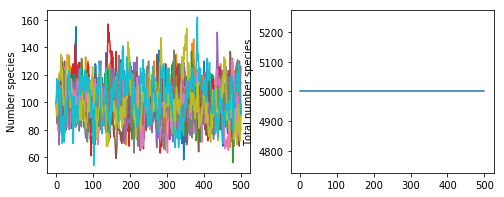

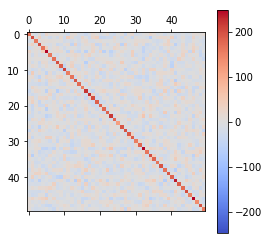

The determinant of the covariance matrix is 2.837E+92.
The Kullback Leibler divergence is 6.59.
The Kullback Leibler divergence is 6.58.
The pvalue of the neutral covariance test is 1.08E-01. (niche p < 0.05, neutral > 0.05)


In [7]:
f = 'test_neutral3.txt' #'DirichletMultinomial.txt'

x_ts = np.loadtxt(f)

plottimeseries(x_ts)

mean = np.mean(x_ts, axis=0)
cov = np.zeros([S,S])

for i in range(S):
    for j in range(S):
        cov[i,j] = np.mean(
            (x_ts[:,i] - mean[i])*(x_ts[:,j] - mean[j]))

vmax = np.max(np.abs(cov))

ax = plt.matshow(cov, cmap='coolwarm', vmin=-vmax, vmax=vmax)
plt.colorbar(ax)
plt.show()

print("The determinant of the covariance matrix is %.3E." % np.linalg.det(cov))

#print(KullbackLeibler(np.loadtxt(f), verbose=True))
print("The Kullback Leibler divergence is %.2f." % KullbackLeibler(np.loadtxt(f)[:,:-1])) #, verbose=True))
print("The Kullback Leibler divergence is %.2f." % KullbackLeibler(np.loadtxt(f)[:,1:])) #, verbose=True))
print("The pvalue of the neutral covariance test is %.2E. (niche p < 0.05, neutral > 0.05)" 
      % neutral_covariance_test(normalize(x_ts), ntests=50, method = 'Kolmogorov'))


In [ ]:
files = ['neutral_timeseries_lambda_' + i + '.txt' for i in ['0.01', '0.01b', '0.01c', '0.1', '0.1b']]

for f in files:
    print(f)
    
    x_ts = np.loadtxt(f)

    fig = plt.figure(figsize=(8,3))

    ax = fig.add_subplot(1,2,1)
    ax.plot(x_ts[::100,::5])
    ax.set_ylabel("Number species")

    ax = fig.add_subplot(1,2,2)
    ax.plot(np.sum(x_ts, axis=1)[::100])
    ax.set_ylabel("Total number species")
    plt.show()

In [ ]:
for f in files:
    print(f)
    
    x_ts = np.loadtxt(f)

    mean = np.mean(x_ts, axis=0)

    # x bar = J/S

    cov_N = np.zeros([S,S])

    for i in range(S):
        for j in range(S):
            cov_N[i,j] = np.mean(
                (x_ts[:,i] - mean[i])*(x_ts[:,j] - mean[j]))

    vmax = np.max(np.abs(cov_N))

    ax = plt.matshow(cov_N, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    plt.colorbar(ax)
    plt.show()

    print("The determinant of the covariance matrix is %.3E." % np.linalg.det(cov_N))

if False:
    cov_diag0 = np.copy(cov); np.fill_diagonal(cov_diag0, 0)

    cov_N = np.zeros([S,S])

    for i in range(S):
        for j in range(S):
            cov_N[i,j] = 2 * 1/S * 1/(S-1) * np.sum(cov_diag0[i,j])
    np.fill_diagonal(cov_N, 1/S*np.sum(np.diag(cov)))

    plt.matshow(cov_N)
    plt.show()

Mean covariance matrix of 8 different simulations of 1e5 steps.

In [ ]:
files = ['neutral/neutral_timeseries_lambda_0.01_dt10_%s.txt' % i for i in map(chr, range(97, 97+3))]

S = 50

cov_N = np.zeros([S,S])

for f in files:
    print(f)
    
    x_ts = np.loadtxt(f)/1000

    mean = np.mean(x_ts, axis=0)

    # x bar = J/S
    
    cov_N_i = np.zeros([S,S])
    
    for i in range(S):
        for j in range(S):
            cov_N_i[i,j] = np.mean(
                (x_ts[:,i] - mean[i])*(x_ts[:,j] - mean[j]))
            
    cov_N = cov_N + cov_N_i
    
    fig = plt.figure(figsize=(8,3))

    plt.plot(x_ts[::100,::5])
    plt.ylabel("Number species")
    plt.savefig(f[:-4] + '-ts.png')
    
    plt.figure()
    vmax = np.max(np.abs(cov_N_i))

    ax = plt.matshow(cov_N_i, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    plt.colorbar(ax)
    plt.savefig(f[:-4] + '-cov.png')
    plt.show()
    print("The determinant of the covariance matrix is %.3E." % np.linalg.det(cov_N_i))
    
cov_N /= len(files)

vmax = np.max(np.abs(cov_N))

ax = plt.matshow(cov_N, cmap='coolwarm', vmin=-vmax, vmax=vmax)
plt.colorbar(ax)

print("The determinant of the covariance matrix is %.3E." % np.linalg.det(cov_N))

# Lotka Volterra model

In [ ]:
from noise_analysis import *

In [ ]:
new = True

S = 50

mu = 0.01 #0.1 # mean interaction strength 
sigma = 0.01 #0.5 # spread interaction strength
omega = 0.3 # noise

f = "Fisheri.csv"

if new:
    steadystate = np.ones([S,1])
    initcond = np.copy(steadystate)

    # interaction
    intmat = - np.random.gamma(mu/S, sigma**2/S, [S,S]); 
    np.fill_diagonal(intmat, -1)

    # no immigration
    mu = np.full([S, 1], lamda)

    # growthrates determined by the steady state
    K = - intmat.dot(initcond).reshape([S,1])

    var = intmat, mu, K, initcond

    dt = 0.005
    T = Nsteps*dt

    if os.path.exists(f):
        os.remove(f)

    run_timeseries_noise(var, noise=omega, f=f, model = MODEL.GLV,
                             noise_implementation=NOISE.LANGEVIN_SQRT, dt=dt, T=T);

In [ ]:
files = ["Fisher.csv", "Fisherb.csv", "Fisheri.csv"]

# Fisher and b: mu = 0.1 and sigma = 0.5
# i has mu = 0.01 and sigma = 0.01

for f in files:
    print(f)
    
    y_ts = pd.read_csv(f, index_col=0)

    fig = plt.figure(figsize=(8,3))

    ax = fig.add_subplot(1,2,1)
    for i in range(1, len(y_ts.columns)-1, 5):
        ax.plot(y_ts.index[::100], y_ts['species_%d' % i][::100])
    ax.set_ylabel("Number species")

    ax = fig.add_subplot(1,2,2)
    ax.plot(np.sum(y_ts.values, axis=1)[::100])
    ax.set_ylabel("Total number species")

    plt.show()

    # normalize number of species per time point, only look at relative abundances

    print("\n Rescale species number per timestep, only consider relative abundances.")

    y_ts_norm = 1000*y_ts.div(y_ts.sum(axis=1), axis=0)

    fig = plt.figure(figsize=(8,3))

    ax = fig.add_subplot(1,2,1)
    for i in range(1, len(y_ts.columns)-1, 5):
        ax.plot(y_ts_norm.index[::100], y_ts_norm['species_%d' % i][::100])
    ax.set_ylabel("Number species")

    ax = fig.add_subplot(1,2,2)
    ax.plot(np.sum(y_ts_norm.values, axis=1)[::100])
    ax.set_ylabel("Total number species")
    plt.show()

Is this distribution multivariate normal?

In [ ]:
fig = plt.figure(figsize=(15,3))

for i in range(1,6):
    ax = fig.add_subplot(1,5,i)
    j = np.random.randint(S)
    k = np.random.randint(S)
    ax.scatter(y_ts.values[::50, j], y_ts.values[::50, k], s=2)

fig = plt.figure(figsize=(15,3))

for i in range(1,6):
    ax = fig.add_subplot(1,5,i)
    j = np.random.randint(S)
    k = np.random.randint(S)
    ax.scatter(y_ts_norm.values[::50, j], y_ts_norm.values[::50, k], s=2)

In [ ]:
files = ["Fisher.csv", "Fisherb.csv", "Fisheri.csv"]

S = 50

for f in files:
    print(f)
    
    y_ts = pd.read_csv(f, index_col=0)
    y_ts_norm = 1000*y_ts.div(y_ts.sum(axis=1), axis=0)

    mean = np.mean(y_ts, axis=0)
    mean_N = np.mean(mean)
    
    # x bar = J/S

    cov = np.zeros([S,S])

    for i in range(S):
        for j in range(S):
            cov[i,j] = np.mean(
                (y_ts.values[:,i] - mean[i])*(y_ts.values[:,j] - mean[j]))

    vmax = np.max(np.abs(cov))

    ax = plt.matshow(cov, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    plt.colorbar(ax)
    plt.show()
    
    cov_diag0 = np.copy(cov); np.fill_diagonal(cov_diag0, 0)
    cov_N = np.sum(cov_diag0)/S/(S-1)*np.ones([S,S])
    np.fill_diagonal(cov_N, np.mean(np.diag(cov)))
    
    eig = np.linalg.eigvals(cov); eig = eig[eig != 0]; pseudodet = np.prod(eig)
    eig = np.linalg.eigvals(cov_N); eig = eig[eig != 0]; pseudodet_N = np.prod(eig)

    KL = 1/2 * ( np.trace(np.dot(np.linalg.pinv(cov_N), cov)) - np.rank(cov_N) 
            + ((mean_N - mean).T).dot(np.linalg.pinv(cov_N)).dot(mean_N - mean)
            - np.log(pseudodet) + np.log(pseudodet_N))
    
    KL_wiki = 1/2 * (np.trace(np.dot(np.linalg.inv(cov_N), cov)) + 
            (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean) 
           - np.rank(cov) + np.log(np.linalg.det(cov_N)/np.linalg.det(cov)))
    
    print("The Kullback Leibler divergence is %.3E (Mehta) or %.3E (wiki)." % (KL, KL_wiki))
        
    if False:
        print("The determinant of the covariance matrix is %.3E." % np.linalg.det(cov))

        print("\n Rescale species number per timestep, only consider relative abundances.")

        mean_norm = np.mean(y_ts_norm, axis=0)

        # x bar = J/S

        cov_norm = np.zeros([S,S])

        for i in range(S):
            for j in range(S):
                cov_norm[i,j] = np.mean(
                    (y_ts_norm.values[:,i] - mean_norm[i])*(y_ts_norm.values[:,j] - mean_norm[j]))

        vmax = np.max(np.abs(cov_norm))

        ax = plt.matshow(cov_norm, cmap='coolwarm', vmin=-vmax, vmax=vmax)
        plt.colorbar(ax)
        plt.show()

        print("Now the determinant of the covariance matrix is %.3E." % np.linalg.det(cov_norm))

Try to reproduce Kullback Leibler divergence as described in Fisher and Mehta supplemental information

In [ ]:
eig = np.linalg.eigvals(cov); eig = eig[eig != 0]; pseudodet = np.prod(eig)
eig = np.linalg.eigvals(cov_N); eig = eig[eig != 0]; pseudodet_N = np.prod(eig)

KL = 1/2 * ( np.trace(np.dot(np.linalg.pinv(cov_N), cov)) - np.rank(cov_N) 
            + ((mean_N - mean).T).dot(np.linalg.pinv(cov_N)).dot(mean_N - mean)
            - np.log(pseudodet) + np.log(pseudodet_N))

print("The Kullback Leibler divergence is %.3E." % KL )

Try to reproduce Kullback Leibler divergence as on Wikipedia page

In [ ]:
KL = 1/2 * (np.trace(np.dot(np.linalg.inv(cov_N), cov)) + 
            (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean) 
           - np.rank(cov) + np.log(np.linalg.det(cov_N)/np.linalg.det(cov)))

print("The Kullback Leibler divergence is %.3E." % KL)
print("The determinants of the covariance matrices are %.3E (neutral) and %.3E (gLV)." 
      % (np.linalg.det(cov_N), np.linalg.det(cov)))

# Reproduction Figure 2B

In [ ]:
def KullbackLeibler(y_ts):
    if isinstance(y_ts, pd.DataFrame):
        y_ts = y_ts.values
        
    if np.all(y_ts == y_ts[0,0]):
        return np.nan        
        
    s = len(y_ts[0])
    mean = np.mean(y_ts, axis=0)
    mean_N = np.mean(mean)
    
    # x bar = J/S

    cov = np.zeros([S,S])

    for i in range(S):
        for j in range(S):
            cov[i,j] = np.mean(
                (y_ts[:,i] - mean[i])*(y_ts[:,j] - mean[j]))
    
    cov_diag0 = np.copy(cov); np.fill_diagonal(cov_diag0, 0)
    cov_N = np.sum(cov_diag0)/S/(S-1)*np.ones([S,S])
    np.fill_diagonal(cov_N, np.mean(np.diag(cov)))
    
    #eig = np.linalg.eigvals(cov); eig = eig[eig != 0]; pseudodet = np.prod(eig)
    #eig = np.linalg.eigvals(cov_N); eig = eig[eig != 0]; pseudodet_N = np.prod(eig)

    KL = 1/2 * (np.trace(np.dot(np.linalg.inv(cov_N), cov)) + 
            (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean) 
           - np.linalg.matrix_rank(cov) + np.log(np.linalg.det(cov_N)/np.linalg.det(cov)))
    
    return KL

In [ ]:
# test Kullback Leibler divergence on neutral timeseries

y_ts = np.loadtxt('neutral/neutral_timeseries.txt')

plottimeseries(y_ts)
plt.show()

s = len(y_ts[0])
mean = np.mean(y_ts, axis=0)
mean_N = np.mean(mean)

# x bar = J/S

cov = np.zeros([S,S])

for i in range(S):
    for j in range(S):
        cov[i,j] = np.mean(
            (y_ts[:,i] - mean[i])*(y_ts[:,j] - mean[j]))

cov_diag0 = np.copy(cov); np.fill_diagonal(cov_diag0, 0)
cov_N = np.sum(cov_diag0)/S/(S-1)*np.ones([S,S])
np.fill_diagonal(cov_N, np.mean(np.diag(cov)))

eig = np.linalg.eigvals(cov); eig = eig[eig != 0]; pseudodet = np.prod(eig)
eig = np.linalg.eigvals(cov_N); eig = eig[eig != 0]; pseudodet_N = np.prod(eig)


print("trace", np.trace(np.dot(np.linalg.inv(cov_N), cov)))
print("mean", (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean))
print("rank", - np.rank(cov))
print("determinants", np.linalg.det(cov_N), np.linalg.det(cov), np.log(np.linalg.det(cov_N)/np.linalg.det(cov)))

fig = plt.figure(figsize=(15,3))

for k in range(1,6):
    ax = fig.add_subplot(1,5,k)
    j = 0
    ax.scatter(y_ts[::50, j], y_ts[::50, k], s=2)

plt.show()

print("covariance ts", cov)
print("covariance neutral", cov_N)

print("The Kullback Leibler divergence of this neutral timeseries is %.3E." % KullbackLeibler(a))

In [ ]:
def Jacobian(intmat, ss, K):
    J = intmat * ss + np.diag((K + intmat.dot(ss)).flatten())

    return J

def is_stable(intmat, ss, K):
    J = Jacobian(intmat, ss, K)

    if np.any(np.real(np.linalg.eigvals(J)) > 0):
        return False
    else:
        return True


In [ ]:
new = False

S = 50 #50

lamda = 0.01
mu = 1 #0.1 # mean interaction strength 
sigmas = np.arange(0,0.22,0.02) #0.5 # spread interaction strength
omegas = np.arange(0.1,1.1,0.1) # noise

Nsteps = 5e7 #5e7
tskip = 99 # 99
dt = 0.005
T = Nsteps*dt 
    
if new:
    for sigma in sigmas:
        for omega in omegas:
            f = "KullbackLeibler/LV-%.2f-%.1f-e.csv" % (sigma, omega)
            
            steadystate = 5*np.ones([S,1])
            initcond = np.copy(steadystate)
            
            stable = False
            
            while not stable:
                # interaction
                if sigma == 0:
                    intmat = np.zeros([S,S])
                else:
                    #intmat = - np.random.gamma(mu/S, sigma**2/S, [S,S])
                    intmat = np.random.normal(0, sigma, [S,S])
                np.fill_diagonal(intmat, -1)

                # no immigration
                mu = np.full([S, 1], lamda)

                # growthrates determined by the steady state
                K = - intmat.dot(initcond).reshape([S,1]) - mu
                
                stable = is_stable(intmat, steadystate, K)
                
                #if not stable:
                #    print("not stable")

            var = intmat, mu, K, initcond
           
            if os.path.exists(f):
                os.remove(f)

            run_timeseries_noise(var, noise=omega, f=f, model = MODEL.GLV,
                                noise_implementation = NOISE.LANGEVIN_LINEAR, #NOISE.SQRT_MILSTEIN, 
                                 dt=dt, T=T, tskip = tskip)

In [ ]:
if True:

    sigmas = np.arange(0,0.22,0.02) #0.5 # spread interaction strength
    omegas = np.arange(0.1,1.1,0.1) # noise

    KL = np.zeros((len(sigmas), len(omegas)))

    for i, sigma in enumerate(sigmas):
        for j, omega in enumerate(omegas):
            print(sigma,omega)
            f = "KullbackLeibler/LV-%.2f-%.1f-e.csv" % (sigma, omega)
            
            ts = pd.read_csv(f, index_col=0, na_values='NAN')
            
            if not ts.isnull().values.any(): # no NAN values
                KL[i,j] = KullbackLeibler(ts)
    
    KL = pd.DataFrame(KL, index=sigmas, columns=omegas)
    KL.to_csv('KullbackLeibler/LV-e.csv')

In [ ]:
KL = pd.read_csv('KullbackLeibler/LV-e.csv', index_col=0)

mat = plt.matshow(KL)
plt.colorbar(mat)
plt.xticks(range(0, KL.shape[1], 2), ['%.1f' % i for i in KL.columns.astype(float)][::2])
plt.yticks(range(0, KL.shape[1], 2), ['%.2f' % i for i in KL.index][::2])
plt.xlabel('Noise')
plt.ylabel('Interaction')

plt.show()

KL = pd.read_csv('KullbackLeibler/LV.csv', index_col=0)

mat = plt.matshow(KL)
plt.colorbar(mat)
plt.xticks(range(0, KL.shape[1], 2), ['%.1f' % i for i in KL.columns.astype(float)][::2])
plt.yticks(range(0, KL.shape[1], 2), ['%.2f' % i for i in KL.index][::2])
plt.xlabel('Noise')
plt.ylabel('Interaction')

plt.show()

In [ ]:
sigma = 0.16
omega = 0.2

f = "KullbackLeibler/LV-%.2f-%.1f-e.csv" % (sigma, omega)
#f = "KullbackLeibler/test.csv"


plottimeseries(pd.read_csv(f, index_col=0, na_values='NAN'))

In [ ]:
y_ts = pd.read_csv(f, index_col=0, na_values='NAN')

S = len(y_ts.columns)
mean = np.mean(y_ts, axis=0)
mean_N = np.mean(mean)

# x bar = J/S

cov = np.zeros([S,S])

for i in range(S):
    for j in range(S):
        cov[i,j] = np.mean(
            (y_ts.values[:,i] - mean[i])*(y_ts.values[:,j] - mean[j]))

cov_diag0 = np.copy(cov); np.fill_diagonal(cov_diag0, 0)
cov_N = np.sum(cov_diag0)/S/(S-1)*np.ones([S,S])
np.fill_diagonal(cov_N, np.mean(np.diag(cov)))
print(cov_N)
#cov_N = np.eye(S)

KL = 1/2 * ( np.trace(np.dot(np.linalg.inv(cov_N), cov)) + 
        (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean) 
       - np.linalg.matrix_rank(cov) + np.log(np.linalg.det(cov_N)/np.linalg.det(cov)))

print(np.trace(np.dot(np.linalg.inv(cov_N), cov)),
        (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean),
       np.linalg.matrix_rank(cov),
      np.log(np.linalg.det(cov_N)/np.linalg.det(cov)),
     np.linalg.det(cov_N), np.linalg.det(cov))

eig = np.linalg.eigvals(cov); eig = eig[eig != 0]; pseudodet = np.prod(eig)
eig = np.linalg.eigvals(cov_N); eig = eig[eig != 0]; pseudodet_N = np.prod(eig)

KL_F = 1/2 * ( np.trace(np.dot(np.linalg.pinv(cov_N), cov)) - np.linalg.matrix_rank(cov_N) 
            + ((mean_N - mean).T).dot(np.linalg.pinv(cov_N)).dot(mean_N - mean)
            - np.log(pseudodet) + np.log(pseudodet_N))

print(np.trace(np.dot(np.linalg.pinv(cov_N), cov)),
      np.linalg.matrix_rank(cov_N),
    ((mean_N - mean).T).dot(np.linalg.pinv(cov_N)).dot(mean_N - mean),
            - np.log(pseudodet) + np.log(pseudodet_N))
print("KL", KL)

# Read and interpret data generated by code of Mehta

average carrying capacity 1.0
std carrying capacity 0.0
average interaction 1.0
std interaction 0.454545
noise strength 0.32768
immigration rate 0.01


<Figure size 600x400 with 0 Axes>

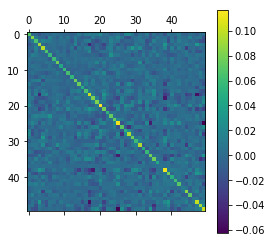

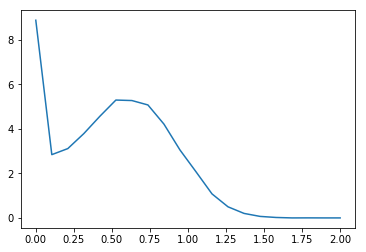

Assuming V is the covariance matrix
trace 50.0
mean 31.8077437981
rank 50
determinant 24.339614101
det neutral, det cov 3.89607316711e-58 1.04729012488e-68
Kullback Leibler 28.0736789496


In [184]:
data = np.loadtxt('Mehta_code/sigma-long.dat', skiprows=1)

i = 0

print("average carrying capacity", data[i, 0])
print("std carrying capacity", data[i, 1])
print("average interaction", data[i, 2])
print("std interaction", data[i, 3])
print("noise strength", data[i, 4])
print("immigration rate", data[i, 5])

mean = data[i, 6:56]

V = np.zeros([50,50]); V[np.triu_indices(50)] = data[i, 56:1331]
V += V.T; np.fill_diagonal(V, np.diag(V)/2)

bins = data[i,1331:1351]

plt.figure()
V_col = plt.matshow(V)
plt.colorbar(V_col)

plt.figure()
plt.plot(np.linspace(0,2,20), bins)
plt.show()

cov = V
S = 50
mean_N = np.mean(mean)

cov_diag0 = np.copy(cov); np.fill_diagonal(cov_diag0, 0)
cov_N = np.sum(cov_diag0)/S/(S-1)*np.ones([S,S])
np.fill_diagonal(cov_N, np.mean(np.diag(cov)))

KL = 1/2 * ( np.trace(np.dot(np.linalg.inv(cov_N), cov)) + 
        (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean) 
       - np.linalg.matrix_rank(cov) + np.log(np.linalg.det(cov_N)/np.linalg.det(cov)))

print("Assuming V is the covariance matrix")
print("trace", np.trace(np.dot(np.linalg.inv(cov_N), cov)))
print("mean", (((mean_N - mean).T).dot(np.linalg.inv(cov_N))).dot(mean_N - mean))
print("rank", np.linalg.matrix_rank(cov))
print("determinant", np.log(np.linalg.det(cov_N)/np.linalg.det(cov)))
print("det neutral, det cov", np.linalg.det(cov_N), np.linalg.det(cov))
print("Kullback Leibler", KL)